# SPKIR CG data deep dive 1.1

In this notebook we use data stored in the kdata drive on the OOI Jupyter Hub. 
<!-- ### Ref Des: CP01CNSM-RID26-08-SPKIRB000 -->

In [79]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from ooi_data_explorations.common import list_methods, list_streams, get_annotations, add_annotation_qc_flags, load_kdata, get_vocabulary, update_dataset
from ooi_data_explorations.uncabled.process_spkir import spkir_datalogger

from ooinet import M2M # not sure if importing just M2M is correct/whether there is a class associated with this module

from qartod_testing.plotting import nanfill_time_gaps

In [80]:
# Set parameters for data request 
refdes = 'GA01SUMO-RID16-08-SPKIRB000'
site, node, sensor = refdes.split('-', 2)

In [81]:
# Create dict of methods and associated data streams
methods = list_methods(site, node, sensor)

streams = {}
for method in methods:
    streams[method] = list_streams(site, node, sensor, method)

streams

{'recovered_host': ['spkir_abj_dcl_instrument_recovered'],
 'telemetered': ['spkir_abj_dcl_instrument']}

In [82]:
# View deployment information
deployments = M2M.get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-SPKIRB-00230,2405,-42.92283,-42.4393,12.0,2015-03-15 21:25:00,2015-11-26 10:08:00,AT26-30,NBP1510
1,2,CGINS-SPKIRB-00299,1342,-42.9246,-42.58668,12.0,2015-11-14 21:06:00,2016-11-08 10:10:00,NBP1510,NBP1609
2,3,CGINS-SPKIRB-00230,2405,-42.9204,-42.440932,12.0,2016-10-27 01:47:00,2018-01-14 10:24:00,NBP1609,AT39-03


In [83]:
# View annotations
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)

if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

annotations
# annotations['annotation'][1]

# Note: now I have moved the lines that add a human-readable date time up here where the annotations are displayed, however I'm not sure if the begin and endDT columns still need 
# to exist. I would like to remove them because they are just taking up space and don't add anything to the dataFrame displayed below.

,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
0,653,GA01SUMO,None,None,None,None,1426454700000,1448532480000,Deployment 1: Buoy log files showed that seawa...,False,lgarzio@marine.rutgers.edu,None,[],2015-03-15T21:25:00,2015-11-26T10:08:00
1,658,GA01SUMO,RID16,08-SPKIRB000,None,None,1426454700000,1448532480000,Deployment 1: The copper bio-shutter was missi...,False,lgarzio@marine.rutgers.edu,None,[],2015-03-15T21:25:00,2015-11-26T10:08:00


The `for` loop above that retrieves the available streams for a given method tells us that each method only has one available data stream. Next, we will download data for the method/stream pairs.

<hr>

### Recovered host data

In [84]:
# Set method and stream strings
method = methods[1]
stream = streams[method][0]
deploy = 1

In [85]:
# load data from the local kdata directory
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


In [86]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [87]:
spkir = nanfill_time_gaps(spkir)

In [88]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 8903, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2015-03-15T21:30:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 18.0 18.0 ... 12.0
    input_voltage                  (station, time) float32 8.49 8.49 ... 7.89
    deployment                     (station, time) float32 1.0 1.0 ... nan 1.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.25
    raw_irradiance_412             (station, time) float32 2.147e+09 ... 2.18...
    raw_irradiance_444             (station, time) float32 2.147e+09 ... 2.19...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 -0.005454 ... 0.2483
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... nan 0.0
    station_name                   (station) <U8 'GA01SUMO'
    lat                            (station) float32 -42.92
    lon                            (station) float32 -42.44
    z                              (station) float32 12.0
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             spkir_abj_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            12.0
    geospatial_vertical_max:            12.0

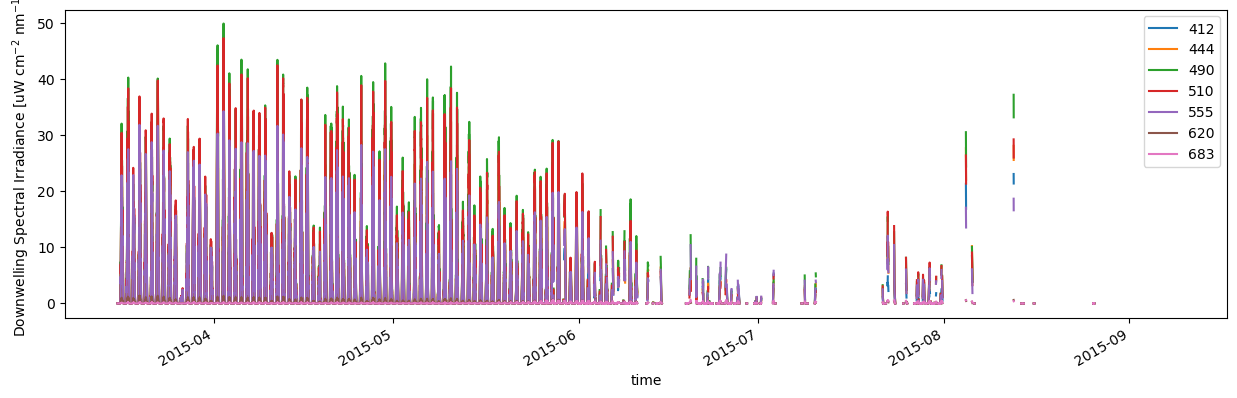

In [89]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

In [ ]:
# From graph above we can see that the plotting function still connects points across gaps in data, so we will add in nan gaps
spkir_full_time = nanfill_time_gaps(spkir)
# dataset_full

Text(0.5, 1.0, 'CP01CNSM-RID26-08-SPKIRB000 recovered_host spkir_abj_dcl_instrument_recovered')

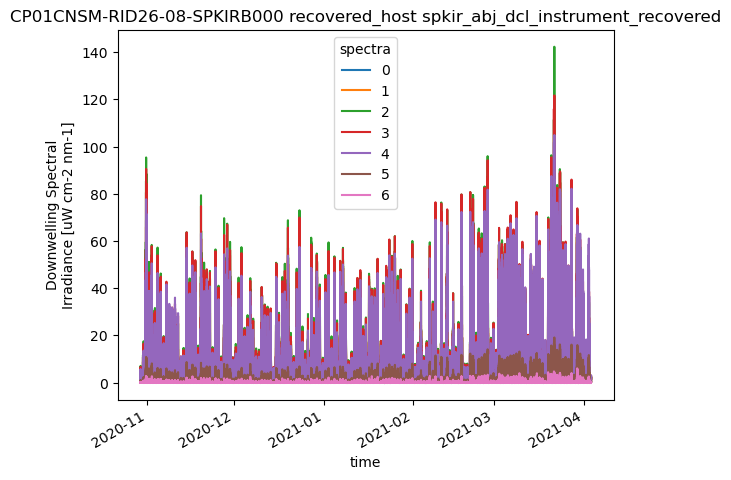

In [53]:
# Plot data with gaps in lines where data is missing
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

In [118]:
# plot a shorter time series around any peaks to see if it affects all channels
spkir_full_time.spkir_abj_cspp_downwelling_vector.sel(time=slice('2015-09-25T12:00','2015-10-15T00:00')).plot.line(x="time", hue="spectra")
plt.title(' '.join([refdes, method, stream]))

TypeError: No numeric data to plot.

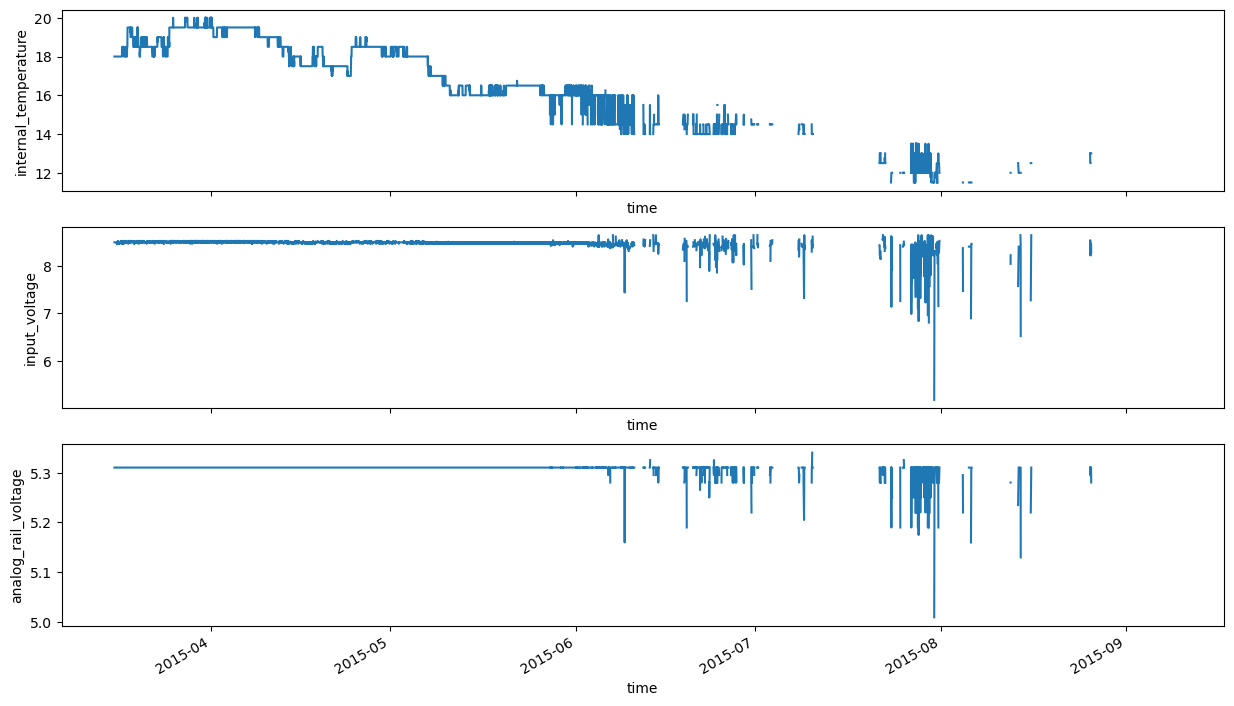

In [90]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Text(0.5, 1.0, 'GS01SUMO-RID16-08-SPKIRB000 recovered_host spkir_abj_dcl_instrument_recovered')

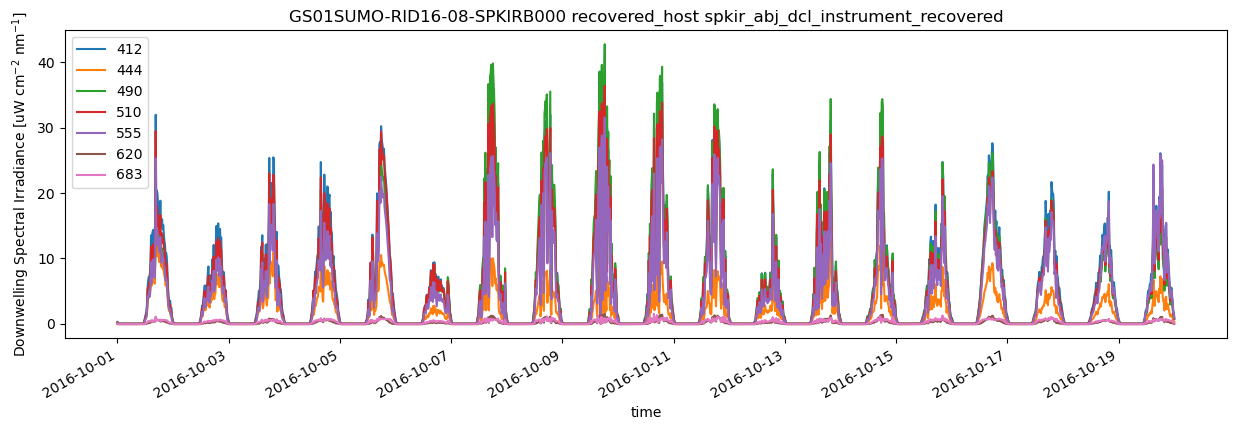

In [35]:
# plotting smaller section of time series to investigate in more detail
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-10-01T00:00','2016-10-20T00:00')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()
plt.title(' '.join([refdes, method, stream]))

In [18]:
# resample to weekly data by applying the median
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="7D").median("time")
# downwelling_irradiance

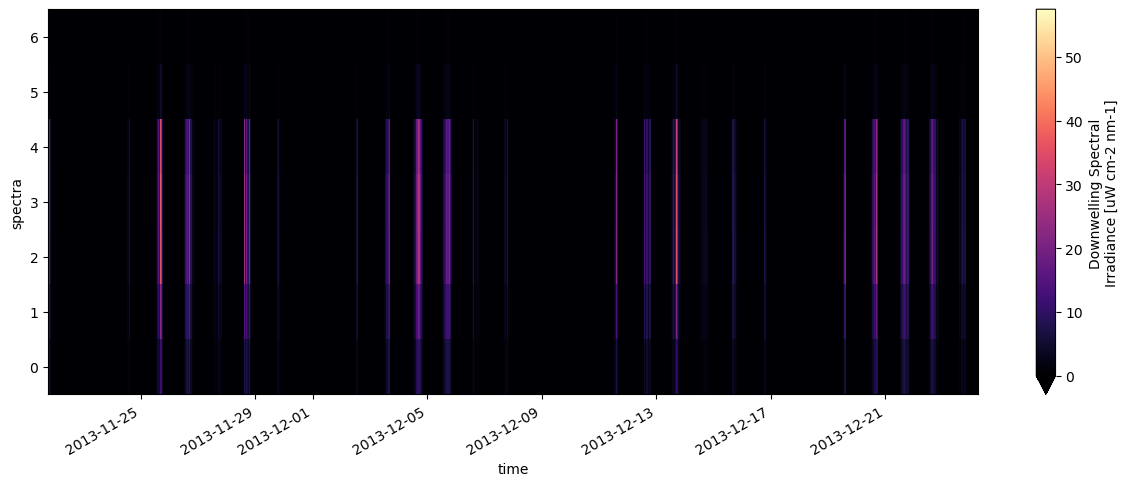

In [22]:
xr.plot.pcolormesh(spkir_full_time.spkir_abj_cspp_downwelling_vector, x="time", y="spectra", cmap='magma', figsize=(15,5), vmin=0)

In [24]:
# create min and max variables to use in full-resolution plot on log-scale cmap
min_spkir = spkir_full_time.spkir_abj_cspp_downwelling_vector.min().values
max_spkir = spkir_full_time.spkir_abj_cspp_downwelling_vector.max().values
print([min_spkir, max_spkir])

[array(-0.0142111), array(57.472907)]


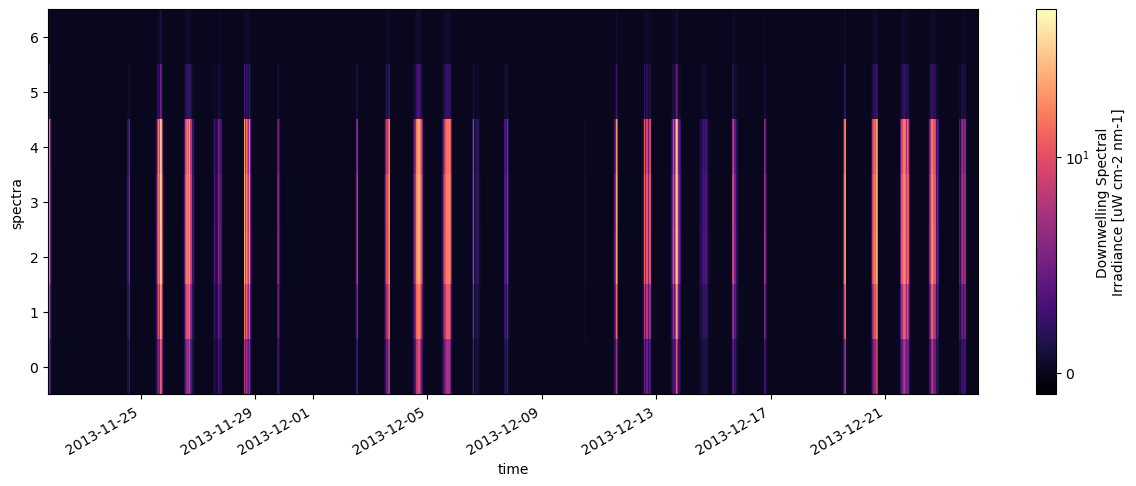

In [20]:
# Trying same plot with full resolution data with log-scale colormap (linear between -1,10)
xr.plot.pcolormesh(spkir_full_time.spkir_abj_cspp_downwelling_vector, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [28]:
# That was a bad idea so let's resample to daily
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="1D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 174, spectra: 7)>
array([[ 9.71255556e+00,  1.33028855e+01,  1.93817753e+01, ...,
         2.23164523e+01,  3.62021577e+00,  7.82912088e-01],
       [ 6.20054185e-01,  9.06080839e-01,  1.34600973e+00, ...,
         1.25914219e+00,  1.82409459e-01,  5.95385999e-02],
       [ 1.73746901e-01,  2.63608506e-01,  3.78101900e-01, ...,
         4.27118953e-01,  6.74665225e-02,  3.25888514e-02],
       ...,
       [ 7.39844170e-02,  7.86333704e-02,  8.35438973e-02, ...,
         5.61443408e-02,  8.31668786e-03,  4.77597635e-03],
       [ 2.28589437e-01,  2.76852485e-01,  3.28657073e-01, ...,
         2.09412793e-01,  2.62619446e-02,  1.17360818e-02],
       [ 2.29803754e-03,  3.92295552e-04, -2.80754229e-04, ...,
        -6.79578805e-04,  1.25565920e-03,  3.28846042e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-07 ... 2019-09-26
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

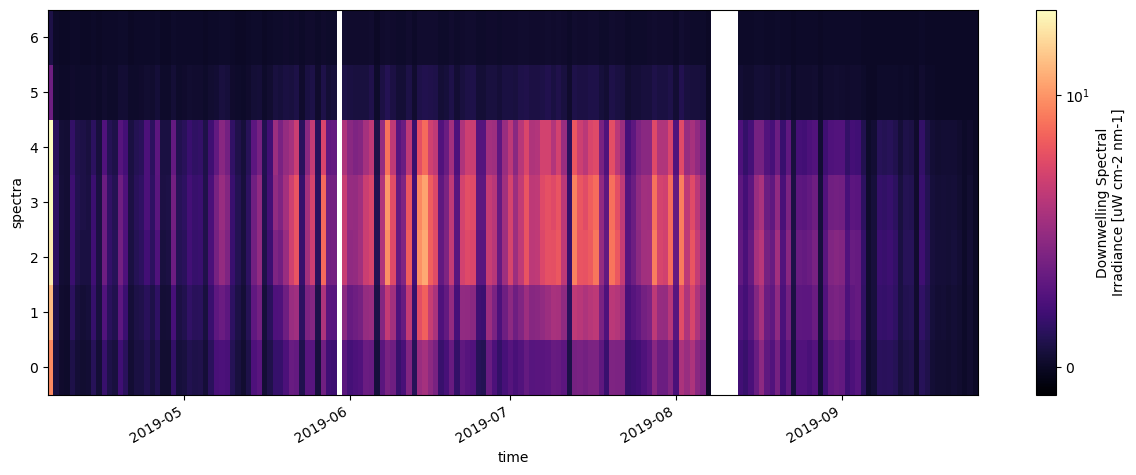

In [30]:
# pcolormesh plot with log-scale cmap except for [-1, 10] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [31]:
# Now lets try this with a 5-day median resample
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="5D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 35, spectra: 7)>
array([[6.82127204e-01, 9.39339140e-01, 1.49556243e+00, 1.66573864e+00,
        1.50775647e+00, 2.17019475e-01, 6.62599682e-02],
       [4.09351526e-01, 5.97971766e-01, 8.23282033e-01, 8.41685295e-01,
        7.24953008e-01, 1.07756459e-01, 4.46083474e-02],
       [1.11149060e+00, 1.63481436e+00, 2.06272259e+00, 1.99825457e+00,
        1.42778278e+00, 2.07900504e-01, 6.89136231e-02],
       [6.33905790e-01, 8.30168475e-01, 1.26737414e+00, 1.37036116e+00,
        1.22211412e+00, 1.81988724e-01, 5.88591173e-02],
       [4.88950510e-01, 7.05335209e-01, 1.08804481e+00, 1.18094031e+00,
        1.09429885e+00, 1.71634988e-01, 5.71144999e-02],
       [6.95715056e-01, 9.77443677e-01, 1.34453113e+00, 1.40168619e+00,
        1.25158622e+00, 1.94583331e-01, 6.10077514e-02],
       [1.77887788e+00, 2.40299210e+00, 3.25211386e+00, 3.32345650e+00,
        2.82799702e+00, 3.63398624e-01, 9.33474496e-02],
       [8.35149703e-01, 1.11870379e+00, 1.48298037e+00, 1.51192503e+00,
        1.28393037e+00, 1.92699171e-01, 5.95294177e-02],
       [1.19328147e+00, 1.70288643e+00, 2.52271664e+00, 2.78847411e+00,
        2.70395010e+00, 3.80136554e-01, 1.00454470e-01],
       [2.62830054e+00, 3.91435216e+00, 5.20132994e+00, 5.24724249e+00,
        4.42306642e+00, 5.73875815e-01, 1.45943075e-01],
...
       [2.06008457e+00, 2.58632186e+00, 3.16383481e+00, 2.98038643e+00,
        2.42941038e+00, 3.60160794e-01, 9.68550489e-02],
       [2.74753531e+00, 3.09858421e+00, 3.49182410e+00, 3.13586101e+00,
        2.39268108e+00, 3.07221372e-01, 8.25675502e-02],
       [2.20276612e+00, 2.58443371e+00, 2.88604360e+00, 2.58521177e+00,
        1.98243281e+00, 2.43159916e-01, 6.05670060e-02],
       [1.66826512e+00, 2.02154214e+00, 2.23259445e+00, 1.97611683e+00,
        1.40635816e+00, 1.69531314e-01, 4.33503864e-02],
       [2.70608963e+00, 3.34031155e+00, 3.58219552e+00, 3.11022829e+00,
        2.22732694e+00, 2.56595992e-01, 6.27982799e-02],
       [7.45937359e-01, 8.52196817e-01, 9.00792402e-01, 7.83724039e-01,
        6.10910023e-01, 8.67380087e-02, 2.31770994e-02],
       [1.05503826e+00, 1.35776975e+00, 1.46589740e+00, 1.28284831e+00,
        9.28877248e-01, 1.16683356e-01, 3.63260056e-02],
       [7.11412936e-01, 9.11214792e-01, 1.05646410e+00, 9.39103459e-01,
        7.16780233e-01, 8.74880143e-02, 2.91914385e-02],
       [3.15291575e-01, 3.98664721e-01, 4.91061523e-01, 4.47583359e-01,
        3.45641780e-01, 4.67864891e-02, 1.80901622e-02],
       [6.95465087e-03, 5.62515071e-03, 3.77377740e-03, 2.68314116e-03,
        3.17550394e-03, 3.19469816e-03, 4.37195968e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-11 ... 2019-09-23
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

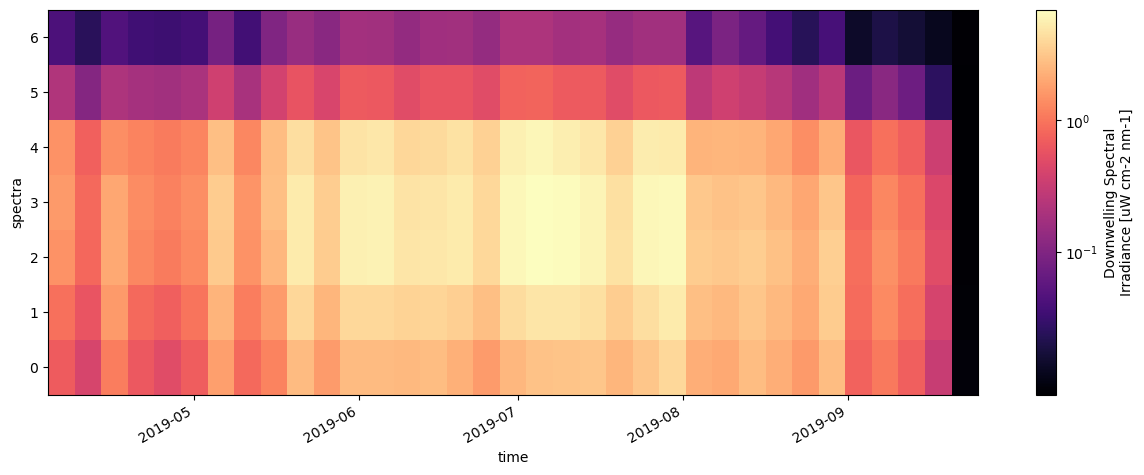

In [37]:
# 5-day median of downwelling spectral irradiance pcolormesh plot with log-scale cmap except for [0, 0.01] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=0.1))